# Universal Path Decomposition of Multilayer Transfer and Scattering Matrices

**Companion Notebook** for the homonymous paper by *Joaquin Garcia-Suarez* (2025)


This notebook provides an interactive implementation of the concepts introduced in the paper. The parameters are chosen to generate the results in Figure 3 of the main text, but they can be modified manually in order to reproduce Figure 2 or Supplementary Figure 1. All computations are based on TE polarization and lossless media.


---

# Initialization and Design Parameters

This code snippet sets up the fundamental constants and design parameters for simulating the optical behavior of a multilayer dielectric structure.

- `numpy` and `matplotlib.pyplot` are imported for numerical computations and plotting.
- `c0` is the speed of light in vacuum, set to $3 \times 10^8 \, \text{m/s}$.
- `design_wavelength` is the central wavelength of interest, chosen as 600 nanometers (orange light), converted to meters.
- `design_freq` computes the **angular frequency** (in radians per second) corresponding to the design wavelength using the formula:

$$
\omega = \frac{2\pi c_0}{\lambda}
$$

This frequency will be used as a reference for setting up layer thicknesses and analyzing frequency response.


In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Constants
c0 = 3e8  # Speed of light in vacuum (m/s)
design_wavelength = 600e-9  # 600 nm in meters
design_freq = 2 * np.pi * c0 / design_wavelength

---


### Layer Properties and Quarter-Wavelength Thicknesses

This section defines the physical and optical properties of the three dielectric layers in the structure:

- **Refractive Indices**:
  - `n1 = 1.45`: Silicon dioxide (SiO₂)
  - `n2 = 3.5`: Gallium Phosphide (GaP)
  - `n3 = 2.4`: Titanium dioxide (TiO₂)

- **Effective Light Speeds**:
  - `c1`, `c2`, `c3`: Speed of light in each material, computed as $c = \frac{c_0}{n}$

- **Layer Transit Times**:
  - `t1`: Time to traverse the first layer, chosen so the layer is a **quarter-wavelength** thick at the design frequency.
  - `t2` and `t3`: Set to half of `t1`, ensuring corresponding layers are also quarter-wavelength thick, possibly for symmetry or a specific optical behavior.

- **Physical Thicknesses**:
  - `l1`, `l2`, `l3`: Computed from \( l = c \cdot t \), yielding actual layer thicknesses for the quarter-wavelength condition.

- **Grouped Parameters**:
  - `ns`: List of refractive indices for easier iteration.
  - `ls`: List of layer thicknesses.
  - `ts`: List of time delays per layer.


In [2]:
# Refractive indices
n1 = 1.45  # SiO2
n2 = 3.5   # GaP
n3 = 2.4   # TiO2

# Layer-specific speeds
c1 = c0 / n1
c2 = c0 / n2
c3 = c0 / n3

# Time in each layer
t1 = np.pi / (2 * design_freq)
t2 = t3 = t1 / 2

# Thicknesses (quarter wavelength)
l1 = c1 * t1
l2 = c2 * t2
l3 = c3 * t3

ns = [n1, n2, n3]
ls = [l1, l2, l3]
ts = [t1, t2, t3]

# Number of layers
NN = len(ts)

---

**Define frequency range to evaluate**

Frequency interval that contains the design frequency

In [3]:
freq_list = np.arange(0.1e14, 10.05e14, 0.05e14)  # in Hz

---

# Computations

Once the parameters have been listed, we move to compute, first with the **Transfer Matrix Method (TMM)**, then evaluating the **path-sum decomposition**

### Transfer Matrix (Layer Propagator)

This function defines the **transfer matrix** (or **propagation matrix**) for a single dielectric layer in the **TE (transverse electric)** polarization case.

The function `T(n, d, omega)` computes the matrix for:
- `n`: refractive index of the layer
- `d`: physical thickness of the layer
- `omega`: angular frequency of the light

The matrix is given by:

$$
T(n, d, \omega) =
\begin{bmatrix}
\cos(k d) & \dfrac{\sin(k d)}{k} \\
- k \sin(k d) & \cos(k d)
\end{bmatrix}
\quad \text{where} \quad k = \dfrac{\omega n}{c_0}
$$

This matrix describes how the electric field (amplitude and gradient) evolves as it propagates through a uniform dielectric layer of thickness $d$ and refractive index $n$.


In [4]:
def T(n, d, omega):
    k = omega * n / c0
    return np.array([
        [np.cos(k * d), np.sin(k * d) / k],
        [-k * np.sin(k * d), np.cos(k * d)]
    ])

---

The next loop computes the trace of the **global transfer matrix** for a stack of $N$ dielectric layers across a range of frequencies.

- `freq_list`: A list of frequencies (in Hz) over which the trace will be evaluated.
- `omega`: The angular frequency $\omega = 2\pi f$.
- `T(n, d, \omega)`: The transfer matrix for a single layer (defined previously).
- `aux_result`: The product of all transfer matrices, representing the entire multilayer structure.
- `trace_list`: Stores pairs of the form $\left( \frac{1}{2} \operatorname{Tr}(T_{\text{total}}), f \right)$.

This value,
$$
\frac{1}{2} \operatorname{Tr}(T_{\text{total}})
$$
is commonly used in optics to identify **transmission band edges** and to analyze the **dispersion relation** in periodic structures.

In [5]:
trace_list = []

for f in freq_list:
    omega = 2 * np.pi * f
    aux_result = T(n1, l1, omega)
    for i in range(1, NN): 
        aux_result = T(ns[i], ls[i], omega) @ aux_result
    trace_list.append([0.5 * np.trace(aux_result), f])


### Path Decomposition Approach

The following snippet implements the path-based method to compute the optical response by enumerating and evaluating all valid light propagation paths through the structure.


#### Path Enumeration

All possible combinations of forward and backward propagation through the layers are generated using binary tuples of $\pm1$ (this results in $2^{N-1} = 4$ valid paths for a 3-layer system).


#### Amplitude Computation

For each valid path, the amplitude is calculated based on a product of interface terms. These terms resemble Fresnel transmission coefficients, accounting for how the electric field amplitude changes at each dielectric interface.

Two distinct contributions (`T11` and `T22`) are computed for each path to account for symmetry in path direction. The final amplitude is the average of these two products. This reflects the fact that a path and its time-reversal have the same optical magnitude in the absence of absorption.


#### Phase Calculation

The phase is given by the dot product between the path vector (with $\pm1$ entries) and the list of time delays, scaled by the angular frequency $\omega$.


#### Path-Based Response Function

The total optical response at a given frequency is reconstructed by summing the cosine of each path's phase, weighted by its amplitude.

Mathematically, the result is:
$$
\frac{1}{2} \operatorname{Tr}(T_{\text{total}})
= \sum_k \mathcal{T}_k \cos(\phi_k)
$$
where $\mathcal{T}_k$ is the amplitude and $\phi_k$ is the phase delay for the contribuation of the $k$-th path to the half-trace.

In [6]:
from itertools import product  # Used to generate all combinations of ±1 path directions

# Generate all NN-element path vectors of ±1, keeping only those that start with +1 (forward entry)
paths = [p for p in product([-1, 1], repeat=NN) if p[0] == 1]

# Compute amplitude for a given path based on interface transmission coefficients
def amplitude(p, ns):
    # T11 term: forward-like contribution
    T11 = np.prod([(1 + p[i-1] * p[i] * ns[i-1] / ns[i]) / 2 for i in range(1, NN)])
    # T22 term: reverse-like contribution 
    T22 = np.prod([(1 + p[i-1] * p[i] * ns[i] / ns[i-1]) / 2 for i in range(1, NN)])
    return 0.5 * (T11 + T22)

# Evaluate for actual values of refraction indices
amplitudes = [amplitude(p, ns) for p in paths]

# Function to compute phase delay for a path
def phase(p, omega, ts):
    return np.dot(p, omega * np.array(ts))  # φ = ω * (p · t)

# Function to compute the half-trace at a given frequency from the path-sum decomposition
def path_decomposition(omega):
    # Get phase for each path
    phases = [phase(p, omega, ts) for p in paths]
    # Sum over all path contributions: amplitude × cos(phase)
    return sum(a * np.cos(phi) for a, phi in zip(amplitudes, phases))


# Visualization

The rest of the notebook plots the earlier results, generating images equivalent to Figure 3c in the main text. 

This plot compares the optical response of a 3-layer dielectric stack computed via the Transfer Matrix Method (TMM) and a path-based decomposition.

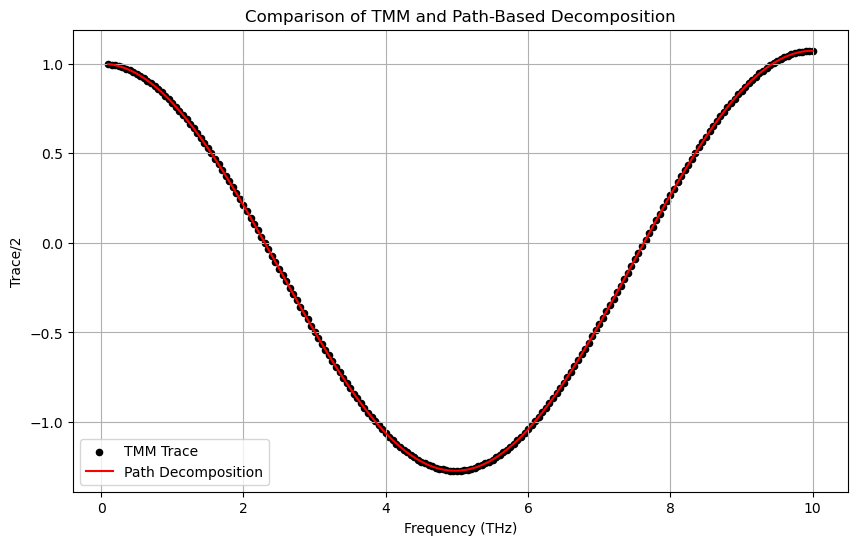

In [7]:
# Plot example: trace comparison
plt.figure(figsize=(10, 6))
trace_vals = np.array(trace_list)

# TMM Trace as scattered points
plt.scatter(trace_vals[:, 1] / 1e14, trace_vals[:, 0], label='TMM Trace', color='black', s=20)

# Path decomposition as dashed red line
path_vals = [path_decomposition(2 * np.pi * f) for f in freq_list]
plt.plot(freq_list / 1e14, path_vals, label='Path Decomposition', color='red', linestyle='-')

# Plot formatting
plt.xlabel('Frequency (THz)')
plt.ylabel('Trace/2')
plt.title('Comparison of TMM and Path-Based Decomposition')
plt.legend()
plt.grid(True)
plt.show()


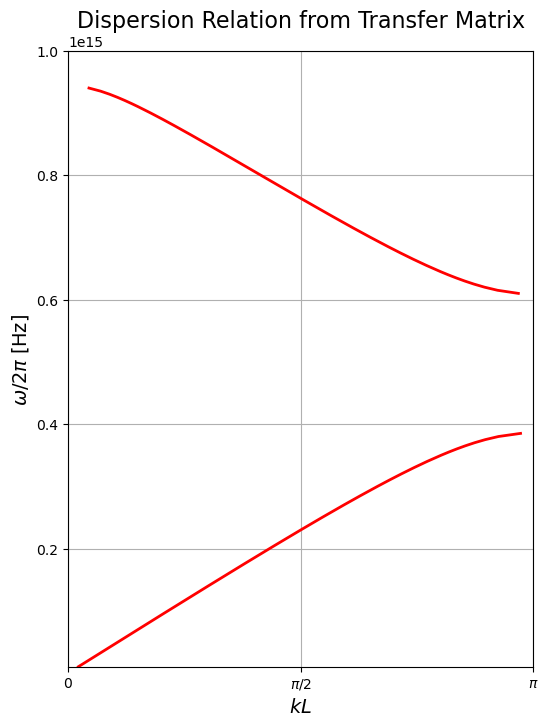

In [8]:
# Compute kL from arccos(half-trace)
half_traces = np.array(trace_list)
valid_indices = np.abs(half_traces) <= 1  # domain of arccos
kL = np.full_like(half_traces, np.nan)
kL[valid_indices] = np.arccos(half_traces[valid_indices])

# Plot dispersion relation
plt.figure(figsize=(6, 8))
plt.plot(kL, freq_list, color='red', linewidth=2)
plt.xlabel(r'$kL$', fontsize=14)
plt.ylabel(r'$\omega / 2\pi$ [Hz]', fontsize=14)
plt.title('Dispersion Relation from Transfer Matrix', fontsize=16)
plt.grid(True)
plt.xlim([0, np.pi])
plt.ylim([freq_list[0], freq_list[-1]])
plt.xticks([0, np.pi / 2, np.pi], [r'$0$', r'$\pi/2$', r'$\pi$'])
plt.show()

This plot shows the contribution of each optical path as a function of its delay time (spectrum of the dispersion relation, Figure 3b).

/tmp/ipykernel_8611/2720166066.py:3: MatplotlibDeprecationWarning: The 'use_line_collection' parameter of stem() was deprecated in Matplotlib 3.6 and will be removed two minor releases later. If any parameter follows 'use_line_collection', they should be passed as keyword, not positionally.
  plt.stem(periods_fs, amplitudes, use_line_collection=True)


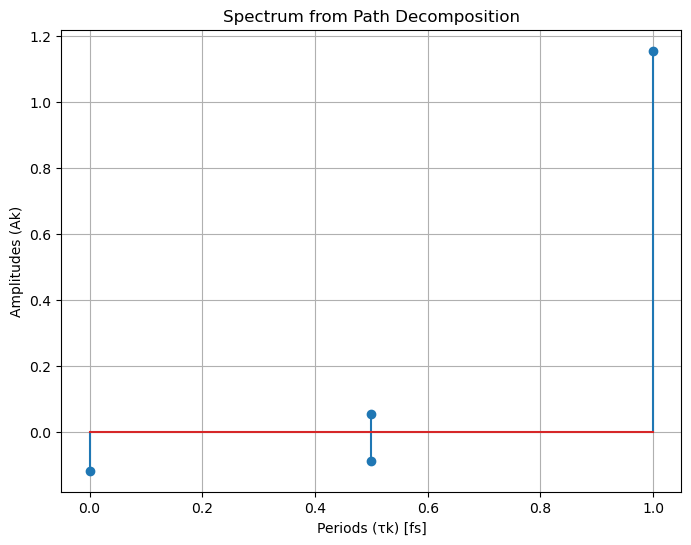

In [9]:
periods_fs = [np.dot(p, ts) * 1e15 for p in paths]  # fs
plt.figure(figsize=(8, 6))
plt.stem(periods_fs, amplitudes, use_line_collection=True)
plt.xlabel('Periods (τk) [fs]')
plt.ylabel('Amplitudes (Ak)')
plt.title('Spectrum from Path Decomposition')
plt.grid(True)
plt.show()
